# 5.2 The Electric Field in a Homogeneous Half Space

Numerical examples of the book  

### Introduction to Controlled-Source Electromagnetic Methods  
Anton Ziolkowski and Evert Slob, 2019, *Cambridge University Press*; ISBN: [9781107058620](https://www.cambridge.org/9781107058620).

- - -
Copyright 2018 Dieter Werthmüller

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0). Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt

%matplotlib inline

### Choose your preferred colour map

The book shows in the chapter black-and-white figures, and in the plate section coloured versions.

In [2]:
plt.rcParams['image.cmap'] = 'viridis'  # Colour
# plt.rcParams['image.cmap'] = 'gray'   # Black-and-white

## Calculation

### Define function to get vertical section

In [3]:
def analytical_xz(src, rec, model):
    """Return ab or total field of a halfspace in xz-plane.
    
    Analytical solutions are only implemented for one depth at a time,
    so we have to loop over z.
    """

    # Get shape from rec
    shape = (rec[2].size, rec[1].size)
    
    # Add source to model
    model['src'] = src
    
    # Define data type depending if frequency- or time-domain
    if model['signal']:
        dtype = float
    else:
        dtype = complex
    
    # Pre-allocate arrays
    total = np.zeros(shape, dtype=dtype)
    total11 = np.zeros(shape, dtype=dtype)
    total21 = np.zeros(shape, dtype=dtype)
    total31 = np.zeros(shape, dtype=dtype)

    # Loop over z
    for i, zval in enumerate(rec[2]):
        # Get receiver for this depth
        model['rec'] = [rec[0], rec[1], zval]
    
        total11[i, :] = epm.analytical(ab=11, **model)
        total21[i, :] = epm.analytical(ab=21, **model)
        total31[i, :] = epm.analytical(ab=31, **model)
        total[i, :] = np.sqrt(np.abs(total11[i, :])**2 +
                              np.abs(total21[i, :])**2 +
                              np.abs(total31[i, :])**2)

    # Return result
    return total11, total21, total31, total


def analytical_t(src, rec, tmodel):
    """Return ab or total field of a halfspace in xt-plane.
    
    Same as analytical_xz, but for time instead of depth. No need to loop.
    """
    
    dd, dr, dair = epm.analytical(src=src, rec=rec, ab='11', solution='dsplit', **tmodel)
    dair[dair==0] = 1e-100  # Replace 0 by small number, because of log plot
    ddr = dd+dr             # Direct and reflected
    ddr[ddr==0] = 1e-100
    
    drespzx = epm.analytical(src=src, rec=rec, ab=31, solution='dhs', **tmodel)
    drespzx[drespzx==0] = 1e-100  # Replace 0 by small number, because of log plot

    drespyx = epm.analytical(src=src, rec=rec, ab=21, solution='dhs', **tmodel)
    drespyx[drespyx==0] = 1e-100  # Replace 0 by small number, because of log plot

    dresp = np.sqrt((ddr+dair)**2 + drespyx**2 + drespzx**2)  # Total field

    return dair, ddr, drespzx, dresp

### General model parameters

In [4]:
# Coordinates
x = np.linspace(-5e3, 5e3, 256)
y = x*0
z = np.linspace(0, 2e3, 128)

# Common model parameters for analytical VTI solution
model = {'res': 1/3.2,          # Resistivity
         'freqtime': 1,         #
         'signal': None,        # Frequency domain
         'solution': 'dhs',     # Diffusive half-space solution
         'verb': 1}             # Verbosity

### Calculate frequency domain as a function of depth

In [5]:
# Adjust model
model['signal'] = None  # Frequency domain
model['freqtime'] = 1   # Frequency 1 Hz

# Deep source
dxz_xx, _, dxz_zx, dxz_tt = analytical_xz([0, 0, 975], [x, y, z], model)

# Shallow source
sxz_xx, _, sxz_zx, sxz_tt = analytical_xz([0, 0, 10], [x, y, z], model)

### Calculate time domain impulse response as a function of depth

In [6]:
# Adjust model
model['signal'] = 0      # Time domain impulse response
model['freqtime'] = 0.5  # Time 0.5 s

# Deep source
tdxz_xx, _, tdxz_zx, tdxz_tt = analytical_xz([0, 0, 975], [x, y, z], model)

# Shallow source
tsxz_xx, _, tsxz_zx, tsxz_tt = analytical_xz([0, 0, 10], [x, y, z], model)

### Calculate time domain impulse and step responses as a function of time

In [7]:
# Offsets and times
xt = np.linspace(100, 5e3, 256)
t = np.logspace(-4, 2, 125)

# Common model parameters for analytical VTI solution
tmodel = {'res': 1/3.2,         # Resistivity
          'freqtime': t,        # Times
          'verb': 1}            # Verbosity

# 1. Impulse response
tmodel['signal'] = 0

# Deep impulse
idair, iddr, idrespzx, idresp = analytical_t([0, 0, 975], [xt, xt*0, 1000], tmodel)

# Shallow impulse
isair, isdr, isrespzx, isresp = analytical_t([0, 0, 10], [xt, xt*0, 35], tmodel)

# 2. Switch-off
tmodel['signal'] = -1

# Deep switch off
sdair, sddr, sdrespzx, sdresp = analytical_t([0, 0, 975], [xt, xt*0, 1000], tmodel)

# Shallow switch-off
ssair, ssdr, ssrespzx, ssresp = analytical_t([0, 0, 10], [xt, xt*0, 35], tmodel)

### Plot settings

In [8]:
def set_axis(ax, x, z):
    """Set some common axes properties."""

    plt.xlabel('Offset (km)')
    
    ax.invert_yaxis()
    
    if x[0] < 0:
        plt.xticks([-5, 0, 5])
    else:
        plt.xticks([1, 2, 3, 4, 5])

    if z[0] == [0]:
        plt.yticks([2, 1, 0])
        plt.ylabel('Depth (km)')
    else:
        plt.ylabel('$\log_{10}(t)$ (s)')
        ax.set_yscale('log')
        plt.yticks([1e-4, 1e-2, 1e0, 1e2], ('-4', '-2', '0', '2'))
    
    return ax


def plot_result(data, x, z, colorbar):
    """Create figure.
    
    Most figures in this section are very similar, and just differ in
    the shown data and the y-axis (depth or time). We can therefore
    define a plot-function which we subsequently call with the different
    results.
    
    """
    n = int(len(data)/2)
    
    # Define figure size, and title depending if 2 or 4 data-sets.
    if n == 3:
        E = [r'$\mathbf{E_{xx}}$', r'$\mathbf{E_{zx}}$', r'$\mathbf{E}$']
        titadd =  2*[r'$\mathbf{y=0}$ m, $\mathbf{\lambda=1}$']
        if colorbar:
            size = (14, 9)
        else:
            size = (14, 7.5)
    else:
        E = [r'$\mathbf{E_{xx;A}}$', r'$\mathbf{E_{xx}-E_{xx;A}}$',
             r'$\mathbf{E_{zx}}$', r'$\mathbf{E}$']
        titadd = [r'$\mathbf{z=1000}$ m, $\mathbf{z_s=975}$ m',
                  r'$\mathbf{z=35}$ m, $\mathbf{z_s=10}$ m']
        if colorbar:
            size = (14, 15)
        else:
            size = (14, 13)
    
    # Start figure
    fig, axs = plt.subplots(figsize=size, nrows=n, ncols=2)
    axs = axs.ravel()
    plt.subplots_adjust(hspace=0.8, wspace=0.15)
    
    # Vertical axis:
    if z[0] == [0]:
        pz = z/1000
    else:
        pz = z
    
    # Loop over data
    for i, val in enumerate(data):
        plt.sca(axs[i])
        tit = r'$\mathbf{log_{10} |}$' + E[i // 2] + r'$|$ at ' + titadd[i % 2]
        plt.title(tit, fontweight='bold')

        # pcolormesh takes x/y as start and end point of pixels,
        # not midpoints. So we have to create these.
        dx = (x[1]-x[0])/2
        px = np.r_[x-dx, x[-1]+dx]/1000
        dz = (pz[1]-pz[0])/2
        pp = np.r_[pz-dz, pz[-1]+dz]
        
        # Plot result
        cs = plt.pcolormesh(px, pp, np.log10(np.abs(val)), vmin=-18, vmax=-8)
        
        # Plot contours at every decade
        cs2 = plt.contour(x/1000, pz, np.log10(np.abs(val)),
                          levels=np.arange(-18, -7),
                          linewidths=0.5, colors=[(0, 0, 0, 0.5)])

        set_axis(axs[i], x, z)

    # Plot colorbar
    if colorbar:
        cax, kw = plt.matplotlib.colorbar.make_axes(axs, location='bottom',
                                                    fraction=.05, pad=0.1,aspect=30)
        cb = plt.colorbar(cs, cax=cax, ticks=[-18, -16, -14, -12, -10, -8], **kw)
    plt.show()

## Figure 5.9

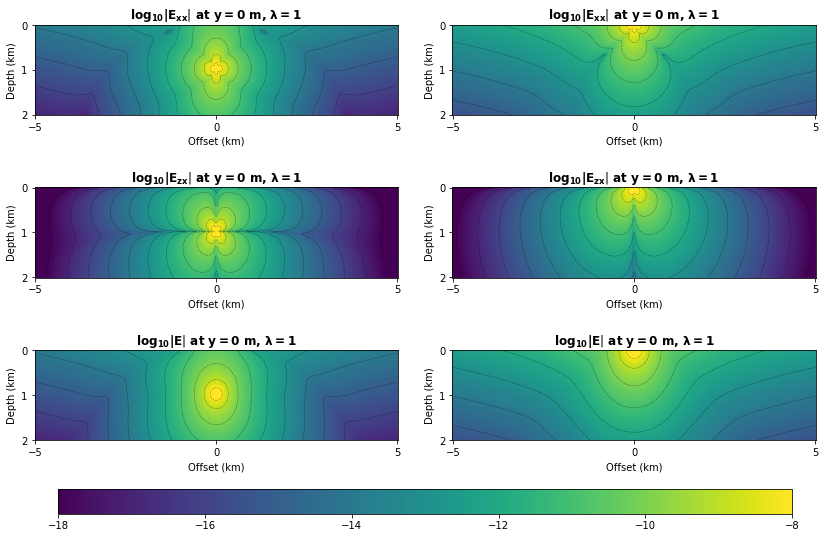

In [9]:
plot_result([dxz_xx, sxz_xx, dxz_zx, sxz_zx, dxz_tt, sxz_tt], x, z, True)

Figure 5.9 The amplitudes of the $x$-component (top) and z-component (middle) of the electric field, and total electric field magnitude (bottom) in the ($x$, $z$)-plane for an $x$-directed electric dipole source operating at 1 Hz at 975 m (left) and 10 m (right) below surface of a conductive half-space with $\sigma$ = 3.2 S/m. The colour bar indicates the amplitude in logarithmic scale.

## Figure 5.10

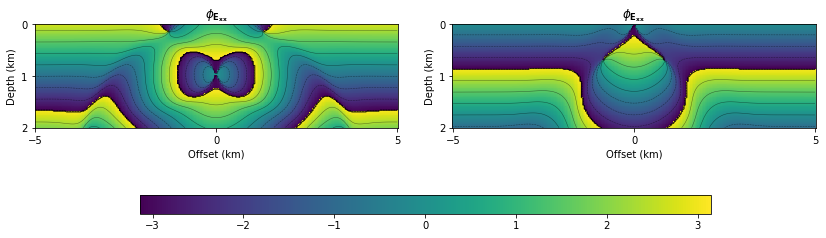

In [10]:
fig, axs = plt.subplots(figsize=(14, 3.5), nrows=1, ncols=2)
axs = axs.ravel()
plt.subplots_adjust(wspace=0.15)

# 1st subplot
for i, val in enumerate([dxz_xx, sxz_xx]):
    plt.sca(axs[i])
    plt.title(r'$\phi_\mathbf{{E_{xx}}}$')

    # pcolormesh takes x/y as start and end point of pixels,
    # not midpoints. So we have to create these.
    dx = (x[1]-x[0])/2
    px = np.r_[x-dx, x[-1]+dx]/1000
    dz = (z[1]-z[0])/2
    pz = np.r_[z-dz, z[-1]+dz]/1000

    # Plot result
    cs = plt.pcolormesh(px, pz, np.angle(val), vmin=-np.pi, vmax=np.pi)
    
    # Plot contours at pi/4-intervals
    cs2 = plt.contour(x/1000, z/1000, np.angle(val),
                      levels=np.arange(-4, 5)*np.pi/4,
                      linewidths=0.5, colors=[(0, 0, 0, 0.5)])

    set_axis(axs[i], x, z)

# Plot colorbar
cax, kw = plt.matplotlib.colorbar.make_axes(axs, location='bottom',
                                            fraction=.1, pad=0.35, aspect=30)
cb = plt.colorbar(cs, cax=cax, ticks=[-3, -2, -1, 0, 1, 2, 3], **kw)

plt.show()

Figure 5.10 The phases of the $x$-component of the electric field in the ($x$, $z$)-plane for a source operating at 1 Hz at 975 m (left) and 10 m (right) below surface of a conductive half-space with $\sigma$ = 3.2 S/m.

## Figure 5.11

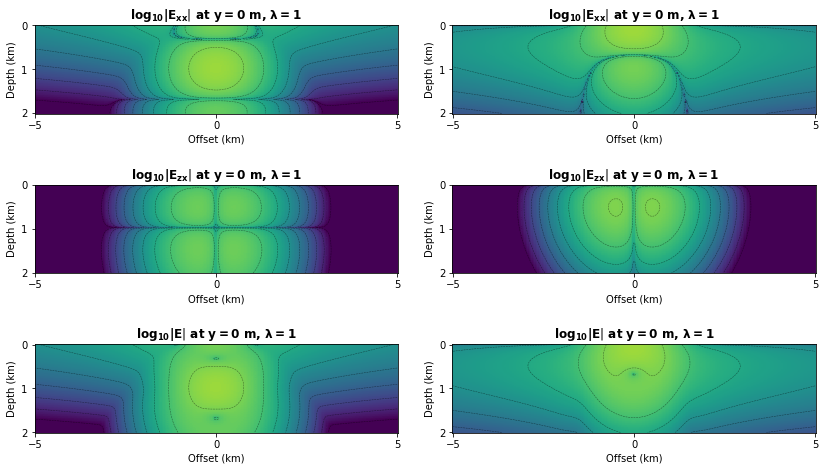

In [11]:
plot_result([tdxz_xx, tsxz_xx, tdxz_zx, tsxz_zx, tdxz_tt, tsxz_tt], x, z, False)

Figure 5.11 Snapshots at $t$ = 0.5 s showing the amplitudes of the $x$-component (top), $z$-component (middle) of the electric field, and total electric field magnitude (bottom) in the ($x$, $z$)-plane for an impulsive source at 975 m (left) and 10 m (right) below surface of a conductive half-space with $\sigma$ = 3.2 S/m.

## Figure 5.12

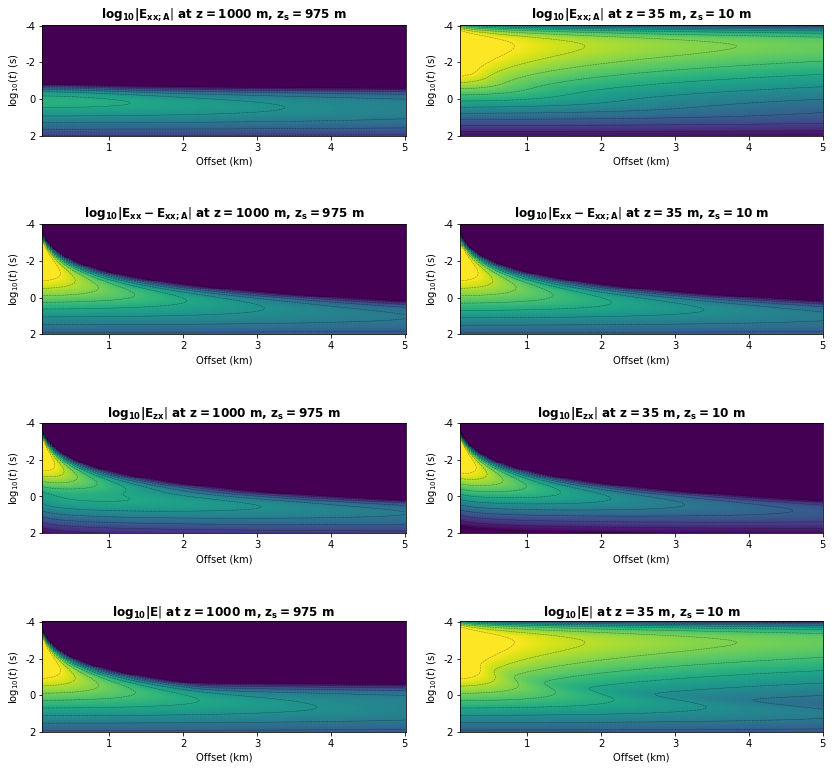

In [12]:
plot_result([idair, isair, iddr, isdr, idrespzx, isrespzx, idresp, isresp], xt, t, False)

Figure 5.12 Amplitudes of the electric field impulse response 25 m below the source decomposed into the air wave (top), direct plus specular reflection (second) in the $x$-component, and $z$-component (third), and total electric field magnitude (bottom) for a source at 975 m (left) and 10 m (right) below the surface of a conductive half-space with $\sigma$ = 3.2 S/m.

## Figure 5.13

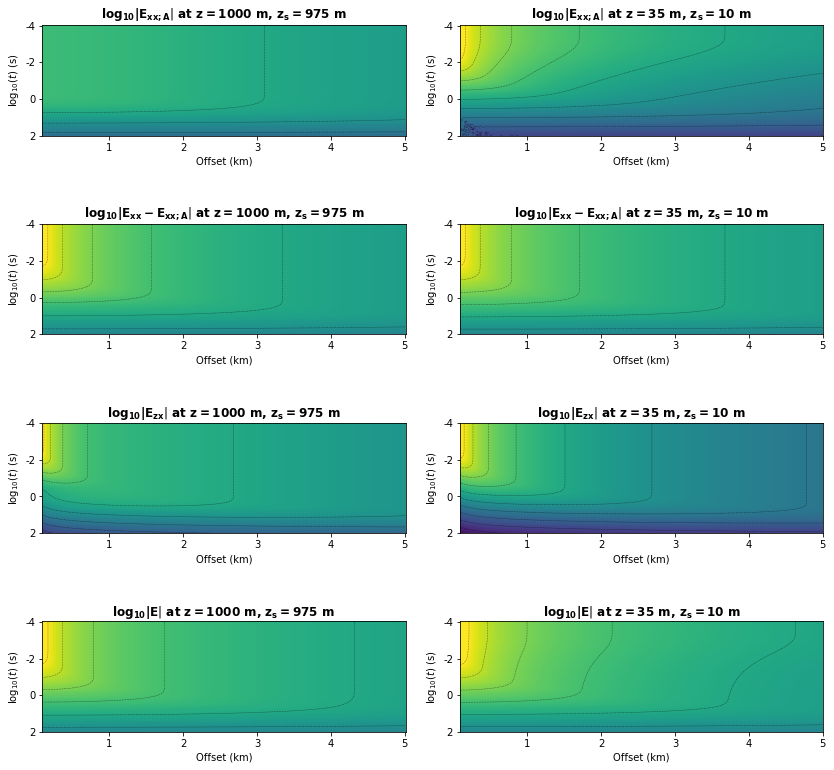

In [13]:
plot_result([sdair, ssair, sddr, ssdr, sdrespzx, ssrespzx, sdresp, ssresp], xt, t, False)

Figure 5.13 Amplitudes of the electric field step switch-off response 25 m below the source decomposed in the air wave (top) and direct plus specular reflection (second) in the $x$-component, and $z$-component (third), and total electric field magnitude (bottom) for a source at 975 m (left) and 10 m (right) below surface of a conductive half-space with $\sigma$ = 3.2 S/m.

## Figure 5.14

### Calculation and plot

Finite length dipoles are implemented in `empymod` in `empymod.bipole`. We use here the fact that the half-space impulse response for source and receiver at the interface for times $t$ > 0$\,s$ is the same as the fullspace impulse response, just the direct wave. (Note that `empymod.bipole` calls internally the analytical fullspace solution if the model is a fullspace and `xdirect=True`.)

In [14]:
# Times
t2 = np.logspace(-2, 3, 61)

# Offsets (km)
off = np.array([1, 3, 5])

# Lengths
srclen = 1000
reclen = 100

# Collect model
model = {'depth': [],        # Fullspace
         'res': 1,           # Resistivity
         'freqtime': t2,     # Time
         'signal': 0,        # Impulse response
         'xdirect': True,    # Assures analytical solution is used
         'verb': 1 }         # Verbosity

# Point dipole calculation
# Here we use the azimuth/dip-definition for source and receivers:
# [x, y, z, azimuth, dip]
point = epm.bipole(src=[0, 0, 0, 0, 0],
                   rec=[1e3*off, np.zeros(off.shape), 0, 0, 0],
                   strength=srclen*reclen,
                   **model)

# Finite dipole calculation
# Here we use the full vector definition for source and receivers:
# [x1, x2, y1, y2, z1, z2]
bpole = epm.bipole(src=[-srclen/2, srclen/2, 0, 0, 0, 0],
                   rec=[1e3*off-reclen/2, 1e3*off+reclen/2, np.zeros(off.shape), np.zeros(off.shape), 0, 0],
                   srcpts=5, recpts=5,  # 5 points for src/rec-integration
                   strength=1, **model)

# Find max amplitude for each offset
maxamp = np.argmax(bpole, 0)

# Calculate relative error
err = np.abs((point-bpole)/bpole)

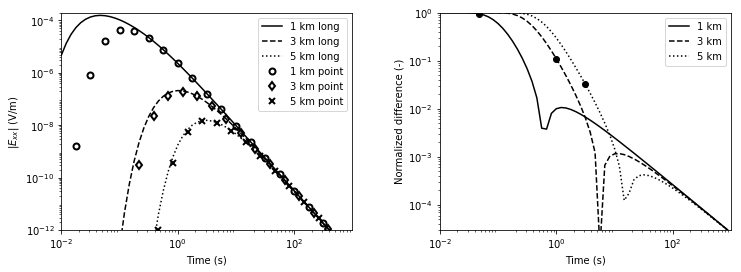

In [15]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=.3)

# 1st subplot: Amplitudes
plt.subplot(121)

# Finite dipoles
for i, val in enumerate(off):
    plt.loglog(t2, bpole[:, i], 'k'+['-', '--', ':'][i], label=str(val)+' km long')

# Point dipoles
for i, val in enumerate(off):
    plt.loglog(t2[i::3], point[i::3, i], 'k'+['o', 'd', 'x'][i], mew=2, mfc='none', label=str(val)+' km point')

plt.xlabel('Time (s)')
plt.ylabel('$|E_{xx}|$ (V/m)')
plt.legend()
plt.xticks([1e-2, 1e0, 1e2])
plt.yticks([1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
plt.xlim([0.01, 1000])
plt.ylim([1e-12, 2e-4])

# 2nd subplot: Error
plt.subplot(122)
for i, val in enumerate(off):
    # Error
    plt.loglog(t2, err[:, i], 'k'+['-', '--', ':'][i], label=str(val)+' km')

    # Add points where max amplitude of finite dipole is
    plt.loglog(t2[maxamp[i]], err[maxamp[i], i], 'ko')

plt.xlabel('Time (s)')
plt.ylabel('Normalized difference (-)')
plt.legend()
plt.xticks([1e-2, 1e0, 1e2])
plt.xlim([0.01, 1000])
plt.ylim([3e-5, 1e0])

plt.show()

Figure 5.14 Homogeneous isotropic half-space impulse response (left plot) with a 1 km source and a 100 m electric dipole at 1, 3 and 5 km offsets (solid, dashed and dotted lines, respectively) at the surface compared with the corresponding point-source–point-receiver responses (circles, diamonds and crosses, respectively); normalised difference between responses with elongated devices and point devices with the location of the maximum amplitudes indicated by dots (right plot).

In [16]:
epm.versions('HTML')